# Chapter 7 Variability of Spike Trains and Neural Codes
Keita Watanabe 2017/08/01 

Note: I use Julia v0.6 in programming sessions as it's the most widely used, popular programming language in our lab.

In [1]:
using PyPlot
using Distributions
using Distributions
using DataFrames
using JSON

# メモ
## 7.1 Spike train variability
Are neurons noisy? -> trial by trial variability
> The variability is visible only if the stimulating current is nearly constant (Fig. 7.3). In fact, when neurons are driven by a current with large-amplitude fluctuations of the input signal, neurons behave more or less deterministically (80; 324).
![](fig7.3.png)

### Source of noise
#### Intrinsic noise
##### Thermal noise
##### Probabilistic nature of finite number of ion channels

> The formulation of the Hodgkin-Huxley equations in terms of ion channel conductivities (see Chapter 2) is implicitly based on the assumption of a large number of ion channels so that fluctuations can be neglected. ... Models that take the finite number of ion channels into account, can reproduce the observed variability of real neurons with intracellular stimulation (456; 96). In particular, they show little spike jitter if the input current is rapidly changing, but are less reliable if the input current is constant.

#### Noise from the Network
> Synaptic transmission failures, for instance, seem to impose a substantial limitation to signal transmission within a neuronal network. Experiments with double electrode recordings from two synaptically connected neurons suggest that only 10–30 percent of presynaptic spikes generate a postsynaptic response (218; 330).

> Finally, an important part of the irregularity of neuronal spiking during spontaneous activity seems to be due to properties of the network – even if the network itself is completely deterministic. -> あとでやる

variabilityについて詳しく調べる-> spike trainに対する統計的記述が必要である

## 7.2 Mean Firing Rate
$$
\nu_{k}={n_{k}^{\rm sp}\over T}\,.
$$

$$
F={\langle(\Delta n^{\rm sp})^{2}\rangle\over\langle n^{\rm sp}\rangle}\,.
$$
where $\langle n^{\rm sp}\rangle$ is mean of ${\rm sp}_k$, $\Delta n^{\rm sp}_{k}=n^{\rm sp}_{k}-\langle n^{\rm sp}\rangle$ 



## Keywords
## The rifing rate
$$
\nu_{k}={n_{k}^{\rm sp}\over T}\,.
$$

## The Fono factor
$$
F={\langle(\Delta n^{\rm sp})^{2}\rangle\over\langle n^{\rm sp}\rangle}\,.
$$
where $\langle n^{\rm sp}\rangle$ is mean of ${\rm sp}_k$, $\Delta n^{\rm sp}_{k}=n^{\rm sp}_{k}-\langle n^{\rm sp}\rangle$ 

* PSTH
* ISI
* Auto correlationとpower spectral densityとの関係


あとhomogeneous/inhomogeneous poisson modelの話をするか？ -> むしろExcersiseの章を使ってPoint processの突っ込んだ話をしたほうが面白いかもしれない...

# 7.1 Spike train variability
Neuron models such as the HH or the IF show a regular spikes with sufficiently storng constant current.
__But__
<br>
<right>![noimg](spikeVar2.png)</right>
Actual neuron fire irregularly. What is the source of the trial variability?

<figure>
<img src="spikeVar1.png">
<figcaption>In vivo. 15 repetitions of the same random dot motion pattern. </figcaption>
<img src="fig7.3.png">
<figcaption>In vitro. Variability across repetitions of the same stimulus. Recorded from a isolated neuron.</figcaption>
</figure>

## Question: What is the source of variability?
* Spike time / membrane potential is not reliable. 
     - fluctuations = noise?
     - relevance for coding
     - source of fluctuations?
     - model of fluctuations?

## Source of noise
* Intrinsic noise
    - Thermal noise
    - Probabilistic nature of finite number of ion channels

> The formulation of the Hodgkin-Huxley equations in terms of ion channel conductivities (see Chapter 2) is implicitly based on the assumption of a large number of ion channels so that fluctuations can be neglected. ... Models that take the finite number of ion channels into account, can reproduce the observed variability of real neurons with intracellular stimulation (456; 96). In particular, they show little spike jitter if the input current is rapidly changing, but are less reliable if the input current is constant.


* Noise from the Network
> Synaptic transmission failures, for instance, seem to impose a substantial limitation to signal transmission within a neuronal network. Experiments with double electrode recordings from two synaptically connected neurons suggest that only 10–30 percent of presynaptic spikes generate a postsynaptic response (218; 330). 

    > ...Finally, an important part of the irregularity of neuronal spiking during spontaneous activity seems to be due to properties of the network – even if the network itself is completely deterministic. -> あとでやる

## Homogeneous Poisson point process
If intervals of events are samples from the exponential distribution, and the intervals are independent each other, then the process is memoryless. __This process is called a homogeneous Poisson point process__.

Probability that a (continuous) random variable $X$ is in $(x, x+dx)$,
$$
P(x < X < x +dx)
$$
Probability density function (PDF)
$$
f(x) = \lim_{dx \to +0} {P(x < X < x +dx) \over dx}
$$
Cumulative distribution function (CDF)
$$
F(x) = P(X \leq x) = \int_{\infty}^x f(s) ds
$$
Survival function
$$
\bar{F}(x) = P(X > x) = 1 - F(x)
$$

## Memoryless process
$$
P(X > s+t | X > t) = P(X > s)
$$
Exponential distribution $f(x) = \lambda e^{-\lambda x}$ satisfy this condition,
$$
P(X > s+t) = P(X > s+t | X > t)P(X > t)
$$
If a distribution satisfies the memoryless property,
$$
P(X > s+t) = P(X > s)P(X > t)
$$
Exponential function satisfies this condition,
$$
P(X > s)P(X > t)  = e^{-\lambda (s+t)} = P(X > s+t)
$$
Density is given by
$$
f(x) = -{d \over dx} P(X > x) = \lambda e^{-\lambda x}
$$

## Why "Poisson" process?
The probability that $n$ spikes happened in $N$ bins $(T=N\Delta)$ follows poisson distribution,
$$
P(N_T = n) = _NC_n (1-\lambda \Delta)^{N-n}(\lambda \Delta)^n \to \frac{(\lambda T)^n}{n!} e^{\lambda T} \text{as} \Delta \to 0
$$

In [2]:
function genpoisson_spiketrain(rate, dt, duration)
    offset = duration
    events = cumsum(rand(Exponential(1/rate), Int64(duration*rate+offset)))
    return round.(events[0 .< events .< duration], Int(-log10(dt)))
end
function genpoisson_spiketrains(ntrials, rate, dt, duration)
    spike_timings = Array{Float64, 1}()
    spike_neurons = Array{Int64, 1}()
    for n in 1:ntrials
        spike_train = genpoisson_spiketrain(rate, dt, duration)
        append!(spike_timings, spike_train)
        append!(spike_neurons, n*ones(length(spike_train)))
    end    
    return DataFrame(trialID = spike_neurons, spiketime = spike_timings, label = ones(spike_neurons))
end

genpoisson_spiketrains (generic function with 1 method)

In [14]:
params = Dict{AbstractString, Real}();
params["rate(Hz)"] = 1;
params["dt(ms)"] = 1;
params["ntrials"] = 10;
params["duration(ms)"] = 120*1000;
spiketrains = genpoisson_spiketrains(params["ntrials"],
    params["rate(Hz)"], params["dt(ms)"]/1000, params["duration(ms)"]/1000);
duration_s = params["duration(ms)"] / 1000;
spiketrain = spiketrains[:spiketime][spiketrains[:trialID] .== 1];

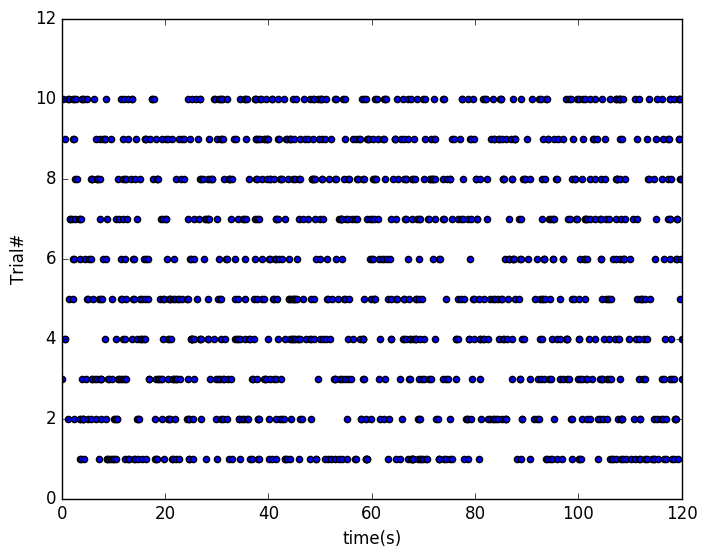

(0, 120)

In [15]:
scatter(spiketrains[:spiketime], spiketrains[:trialID])
ylabel("Trial#"); xlabel("time(s)"); xlim(0, 120)

## 7.2 Mean Firing Rate
### Mean Firing Rate
The firing rate in trial $k$ is the spike count $n_{k}^{\rm sp}$ in an interval of duration $T$ divided by $T$.
$$
\nu_{k}={n_{k}^{\rm sp}\over T}\,.
$$



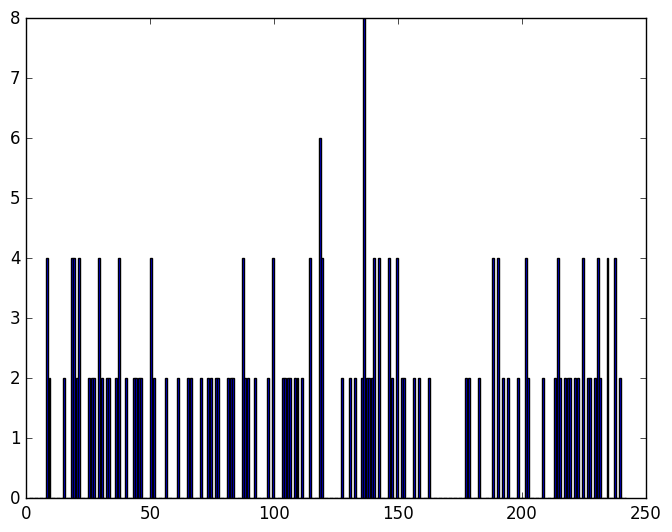

mean(mfr) = 1.037344398340249


1.037344398340249

In [16]:
meanFR(spiketrain, duration_s, interval=.5) = [
    length(spiketrain[t .< spiketrain .< t+interval])/interval 
    for t in 0:interval:duration_s];
mfr = meanFR(spiketrain, duration_s)
plt[:bar](1:length(mfr), mfr);
@show mean(mfr)

### Fano Factor
Let us denote the spike count in trial $k$ by the variable $n^{\rm sp}_{k}$, 
$$
F={\langle(\Delta n^{\rm sp})^{2}\rangle\over\langle n^{\rm sp}\rangle}\,.
$$
where $\langle n^{\rm sp}\rangle$ is mean of ${\rm sp}_k$, $\Delta n^{\rm sp}_{k}=n^{\rm sp}_{k}-\langle n^{\rm sp}\rangle$ 



In [20]:
function fanofactor(spiketrains)
    spikecounts = [length(spiketrains[:trialID][spiketrains[:trialID] .== ID]) for ID in 1:params["ntrials"]];
    meanspikecounts = mean(spikecounts)
    variability_of_spikecounts = spikecounts .- meanspikecounts
    fano = mean(variability_of_spikecounts .^ 2) / meanspikecounts    
    return(fano)
end
@show fanofactor(spiketrains)

fanofactor(spiketrains) = 0.9522842639593907


0.9522842639593907

## PSTH, Rate as a Population activity
$$
\rho(t)={1\over\Delta t}{n_{K}(t;t+\Delta t)\over K}\,.
$$
以下スライドを作っていないので教科書参照

# Interval distribution and coefficient of variation

# Three difinitions of Rate code

#  Stochastic spike arrival

# Stochastic spikje iring

# Poisson process